<h1>Logistic Regression: 2 Classes<h1>
<h3>Seperating target data into magnetic and magnetic classes<h3>

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('full_mag_insulators.csv')

In [3]:
# Drop rows with missing values in features or target
df = df.dropna(subset=['ordering'])

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


<h4>Create model and validate using 2 classes.<h4>

In [13]:
# Separate features and target
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
extra_cols = ['is_gap_direct', 'is_stable']
#['symmetry', 'elements', 'chemsys', 'formula', 'composition', 'structure']
categorical_cols = ['symmetry', 'elements', 'chemsys']

# Prepare X
X = df[numerical_columns + extra_cols + categorical_cols]

# combine all magnetic ordering types into two classes: Magnetic and Non-Magnetic
df["ordering"] = df["ordering"].replace({"FM": "Magnetic", "FiM": "Magnetic", "AFM": "Magnetic"})
y = df["ordering"]

# Split first into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Frequency encode high-cardinality categorical columns
for col in categorical_cols:
    freq = X_train[col].value_counts()
    X_train[col + '_freq'] = X_train[col].map(freq)
    X_val[col + '_freq'] = X_val[col].map(freq).fillna(0)

# Drop original high-cardinality columns
X_train = X_train.drop(columns=categorical_cols)
X_val = X_val.drop(columns=categorical_cols)

# One-hot encode the last two columns
X_train = pd.get_dummies(X_train, columns=extra_cols)
X_val = pd.get_dummies(X_val, columns=extra_cols)

# Align columns
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42))
])

scores = cross_val_score(pipe, X_train, y_train, cv=4, scoring='accuracy')
print(f"Cross-validated accuracy scores: {scores}")
print(f"Mean accuracy: {scores.mean():.3f}")

Cross-validated accuracy scores: [0.7543497  0.74849268 0.73540052 0.73987941]
Mean accuracy: 0.745


In [14]:
# Fit on full training set and evaluate on validation set
pipe.fit(X_train, y_train)
val_accuracy = pipe.score(X_val, y_val)
print(f"Val set accuracy: {val_accuracy:.3f}")

Val set accuracy: 0.743


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report


Classification Report:
              precision    recall  f1-score   support

    Magnetic       0.73      0.70      0.72      3573
          NM       0.75      0.78      0.77      4168

    accuracy                           0.74      7741
   macro avg       0.74      0.74      0.74      7741
weighted avg       0.74      0.74      0.74      7741



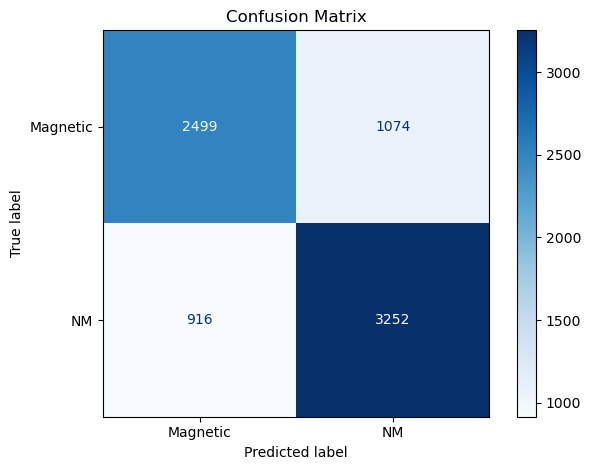

In [15]:
# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

# Predict on the validation set
y_pred = pipe.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=pipe.named_steps['clf'].classes_))

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=pipe.named_steps['clf'].classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.named_steps['clf'].classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


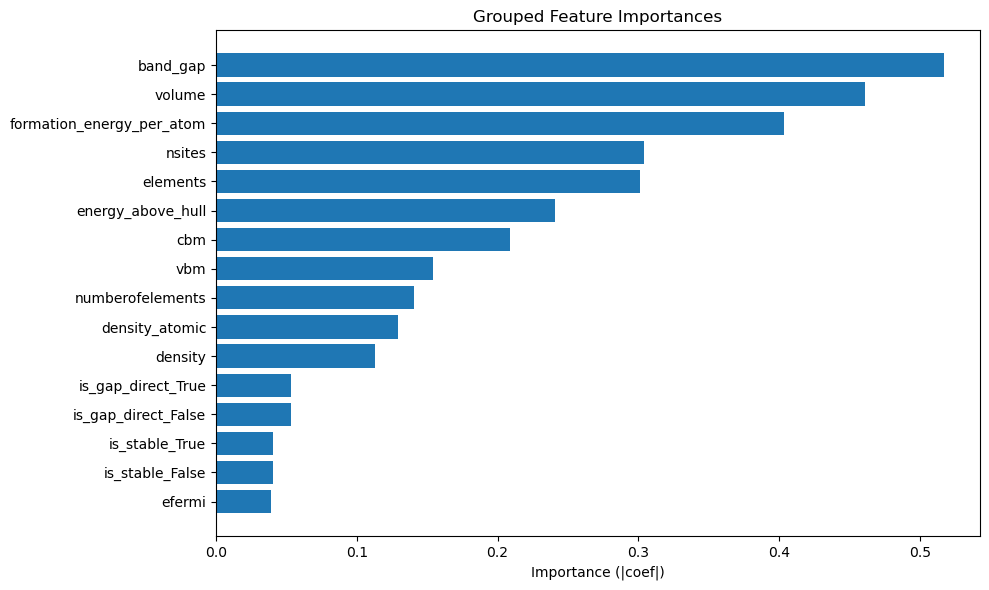

In [12]:
pipe.fit(X_train, y_train)

# For multinomial, take mean absolute value across classes
coefs = np.abs(pipe.named_steps['clf'].coef_).mean(axis=0)
feat_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": coefs
})

numerical_features = numerical_columns
# Add one-hot encoded columns for is_stable and is_gap_direct
onehot_cols = [col for col in X_train.columns if col.startswith('is_stable') or col.startswith('is_gap_direct')]
numerical_features += onehot_cols
numerical_df = feat_df[feat_df["feature"].isin(numerical_features)]
element_importance = feat_df[~feat_df["feature"].isin(numerical_features)]["importance"].sum()

grouped_df = pd.concat([
    numerical_df,
    pd.DataFrame([{"feature": "elements", "importance": element_importance}])
], ignore_index=True)

grouped_df = grouped_df.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(grouped_df["feature"], grouped_df["importance"])
plt.xlabel("Importance (|coef|)")
plt.title("Grouped Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
AFM_count = np.sum(y_val == 'AFM')
print(AFM_count)

683
